# 🏦 Bank Customer Churn Prediction
## Notebook 2 — Exploratory Data Analysis (EDA)

**Goal of EDA:** Before building any model, we need to *understand the data* deeply. EDA answers:
1. How is each feature distributed?
2. Is the target variable balanced?
3. Are there correlations between features?
4. Are there any features that are essentially duplicates of the target?

The insights from EDA directly guide our cleaning and modelling decisions.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Global plot style — makes all charts look clean and professional
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (10, 5)

# to run in your terminal, you may need to update the path to your CSV file
data = pd.read_csv('Customer-Churn-Records.csv')

print('Data loaded:', data.shape)

Data loaded: (10000, 18)


## 1. Missing Values

Before plotting anything, confirm there are no missing values.  
A **heatmap of nulls** is a compact visual way to do this:
- A uniform solid colour means no missing values.
- Gaps or contrasting colours indicate missing data.

In [9]:
missing = data.isnull().sum()
print('Missing values per column:')
print(missing[missing > 0] if missing.any() else 'None — dataset is complete ✓')

# Visual check in this case not necesary due to the fact that there are no missing values, but here is one way how you would do it:
#fig, ax = plt.subplots(figsize=(14, 3))
#sns.heatmap(data.isnull(), cbar=False, cmap='viridis', ax=ax)
#ax.set_title('Missing Values Heatmap  (uniform colour = no missing data)', fontsize=13)
#plt.tight_layout()
#plt.show()

Missing values per column:
None — dataset is complete ✓


## 2. Target Variable Distribution

The target variable `Exited` is **binary**: 1 = churned, 0 = stayed.  
Understanding class balance is critical because:
- If 95% of customers are in class 0, a model that *always predicts 0* achieves 95% accuracy — but is useless.
- **Class imbalance** requires resampling techniques (we will use SMOTE in N4).

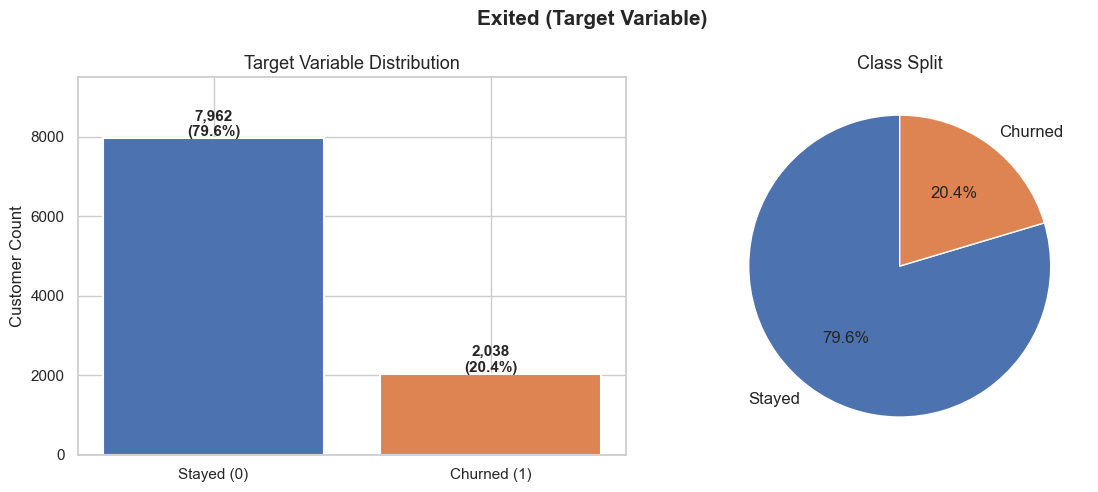


Class counts:
Exited
0    7962
1    2038
Name: count, dtype: int64

⚠️  Imbalance ratio  →  Stayed : Churned  ≈  3.9 : 1
   This must be corrected before training (see N4 — SMOTE).


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
value_counts = data['Exited'].value_counts()
axes[0].bar(['Stayed (0)', 'Churned (1)'], value_counts.values,
            color=['#4C72B0', '#DD8452'], edgecolor='white', linewidth=1.5)
for i, v in enumerate(value_counts.values):
    axes[0].text(i, v + 50, f'{v:,}\n({v/len(data)*100:.1f}%)',
                 ha='center', fontsize=11, fontweight='bold')
axes[0].set_title('Target Variable Distribution', fontsize=13)
axes[0].set_ylabel('Customer Count')
axes[0].set_ylim(0, 9500)

# Pie chart
axes[1].pie(value_counts.values, labels=['Stayed', 'Churned'],
            colors=['#4C72B0', '#DD8452'], autopct='%1.1f%%',
            startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Class Split', fontsize=13)

plt.suptitle('Exited (Target Variable)', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print('\nClass counts:')
print(data['Exited'].value_counts())
print(f'\n⚠️  Imbalance ratio  →  Stayed : Churned  ≈  {value_counts[0]/value_counts[1]:.1f} : 1')
print('   This must be corrected before training (see N4 — SMOTE).')

## 3. Numerical Features — Distributions

We drop the identifier columns before analysis (`RowNumber`, `CustomerId`, `Surname`) since they carry no predictive information.  

We use **histograms with KDE** (Kernel Density Estimate) curves to visualise each numerical feature's distribution:
- **KDE** is a smooth approximation of the probability density.
- Skewness, multi-modality, and outliers are all visible.

Numerical features: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Complain', 'Satisfaction Score', 'Point Earned']


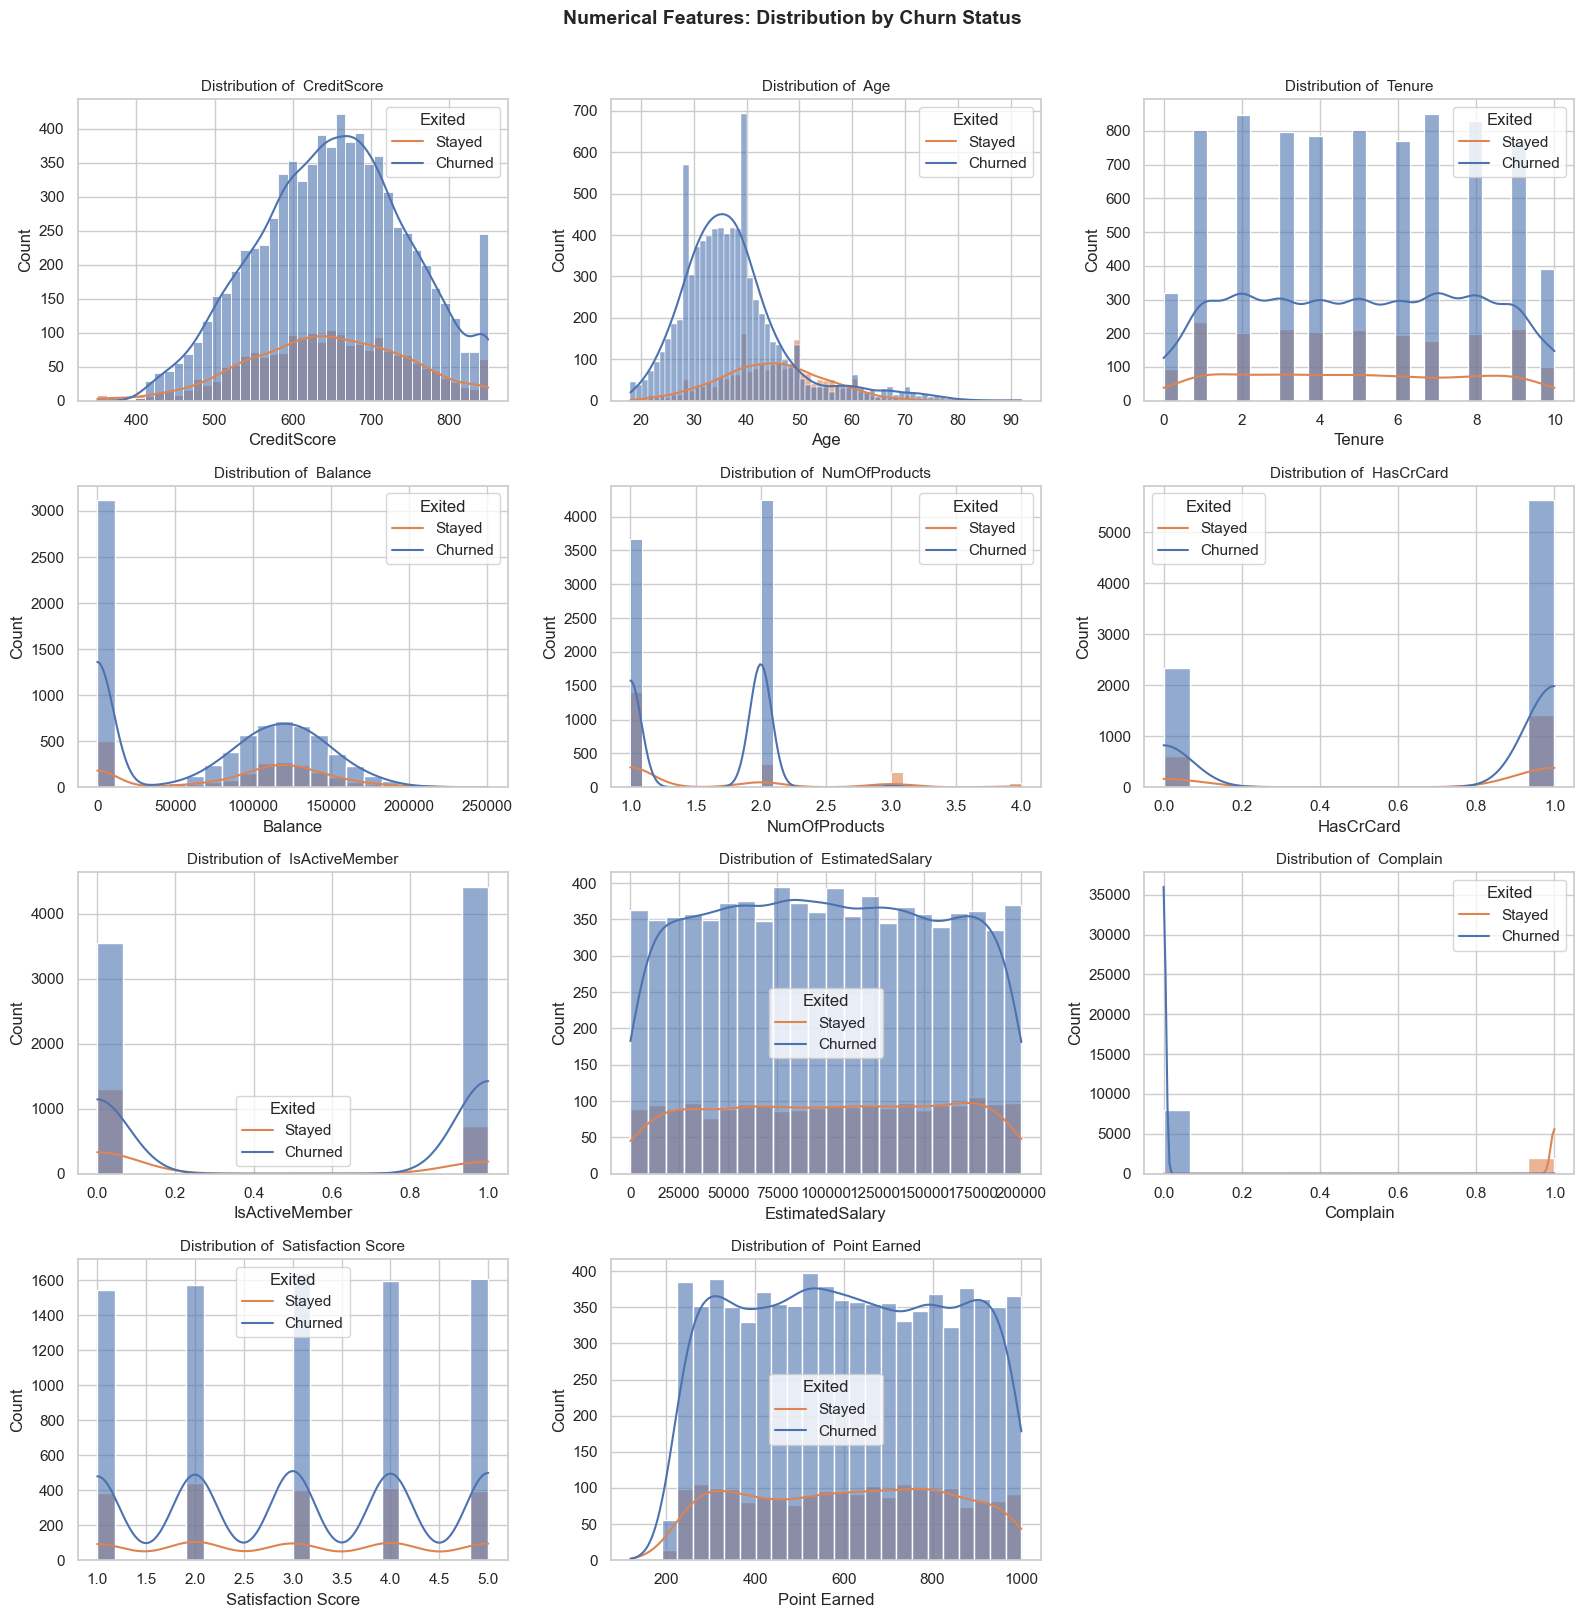

In [4]:
df = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
# Remove the target from the feature distributions
numerical_cols = [c for c in numerical_cols if c != 'Exited']

print('Numerical features:', numerical_cols)

n_cols = 3
n_rows = -(-len(numerical_cols) // n_cols)   # ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    # Overlay two histograms: Stayed vs Churned — reveals if the feature separates classes
    sns.histplot(data=df, x=col, hue='Exited', kde=True, ax=axes[i],
                 palette={0: '#4C72B0', 1: '#DD8452'}, alpha=0.6)
    axes[i].set_title(f'Distribution of  {col}', fontsize=11)
    axes[i].set_xlabel(col)
    axes[i].legend(labels=['Stayed', 'Churned'], title='Exited')

# Hide any unused subplot panels
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Numerical Features: Distribution by Churn Status', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

**Distribution insights:**
- **Age** — Churned customers are noticeably older (distribution shifts right). Strong predictive signal.
- **Balance** — Large spike at 0 (customers with no balance). Churned customers are more spread across mid-high balances.
- **CreditScore** — Near-uniform distribution; both classes look similar (weaker predictor).
- **NumOfProducts** — Customers with 3–4 products churn heavily. Non-linear pattern — tree models will capture this well.
- **IsActiveMember** — Binary feature; inactive members churn more.
- **Point Earned / Satisfaction Score / Tenure** — Roughly uniform; limited visual separation between classes.

## 4. Categorical Features — Count Plots

Categorical features: ['Geography', 'Gender', 'Card Type']


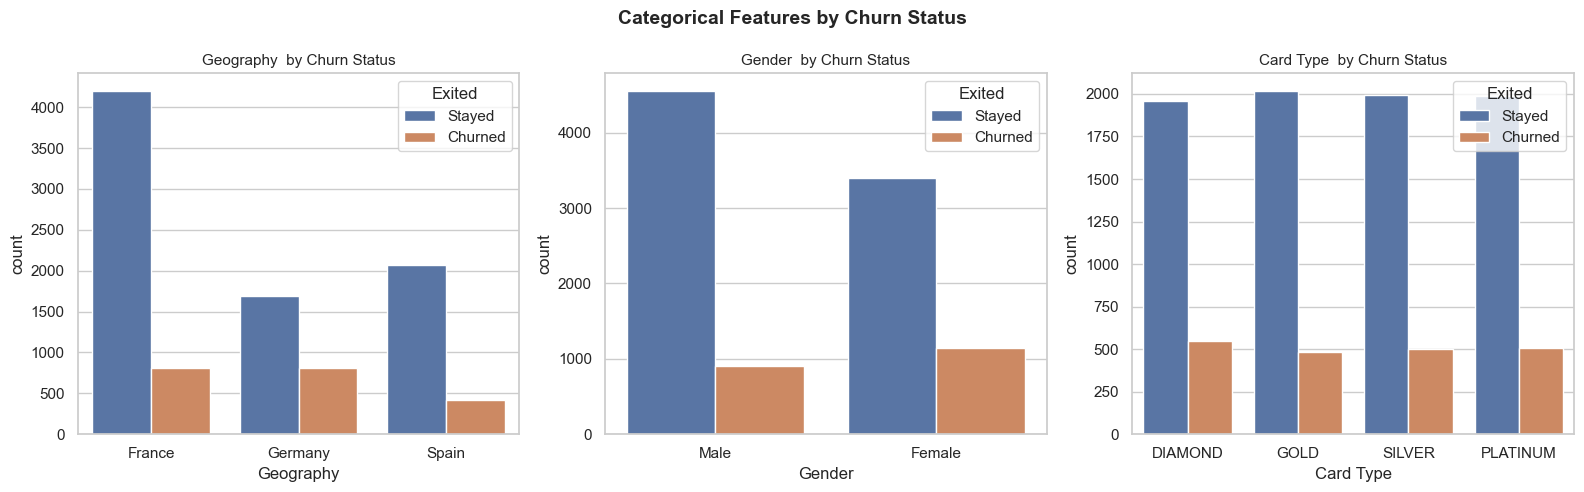

In [5]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
print('Categorical features:', categorical_cols)

fig, axes = plt.subplots(1, len(categorical_cols), figsize=(16, 5))

for i, col in enumerate(categorical_cols):
    # hue='Exited' splits each bar into Stayed / Churned — shows churn rate per category
    sns.countplot(data=df, x=col, hue='Exited',
                  order=df[col].value_counts().index,
                  palette={0: '#4C72B0', 1: '#DD8452'}, ax=axes[i])
    axes[i].set_title(f'{col}  by Churn Status', fontsize=11)
    axes[i].set_xlabel(col)
    axes[i].legend(labels=['Stayed', 'Churned'], title='Exited')

plt.suptitle('Categorical Features by Churn Status', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Categorical insights:**
- **Geography** — Germany has a disproportionately high churn rate relative to its share of customers.
- **Gender** — Female customers churn slightly more than males.
- **Card Type** — All card types have similar churn proportions; limited predictive power alone.

These will be one-hot encoded in N4.

## 5. Correlation Analysis

A **correlation matrix** measures the linear relationship between each pair of numerical features.
- Values range from **-1** (perfect negative correlation) to **+1** (perfect positive correlation).
- Values near **0** indicate little to no linear relationship.
- **High correlation between a feature and the target** → likely a strong predictor.
- **High correlation between two features** → potential redundancy (multicollinearity).

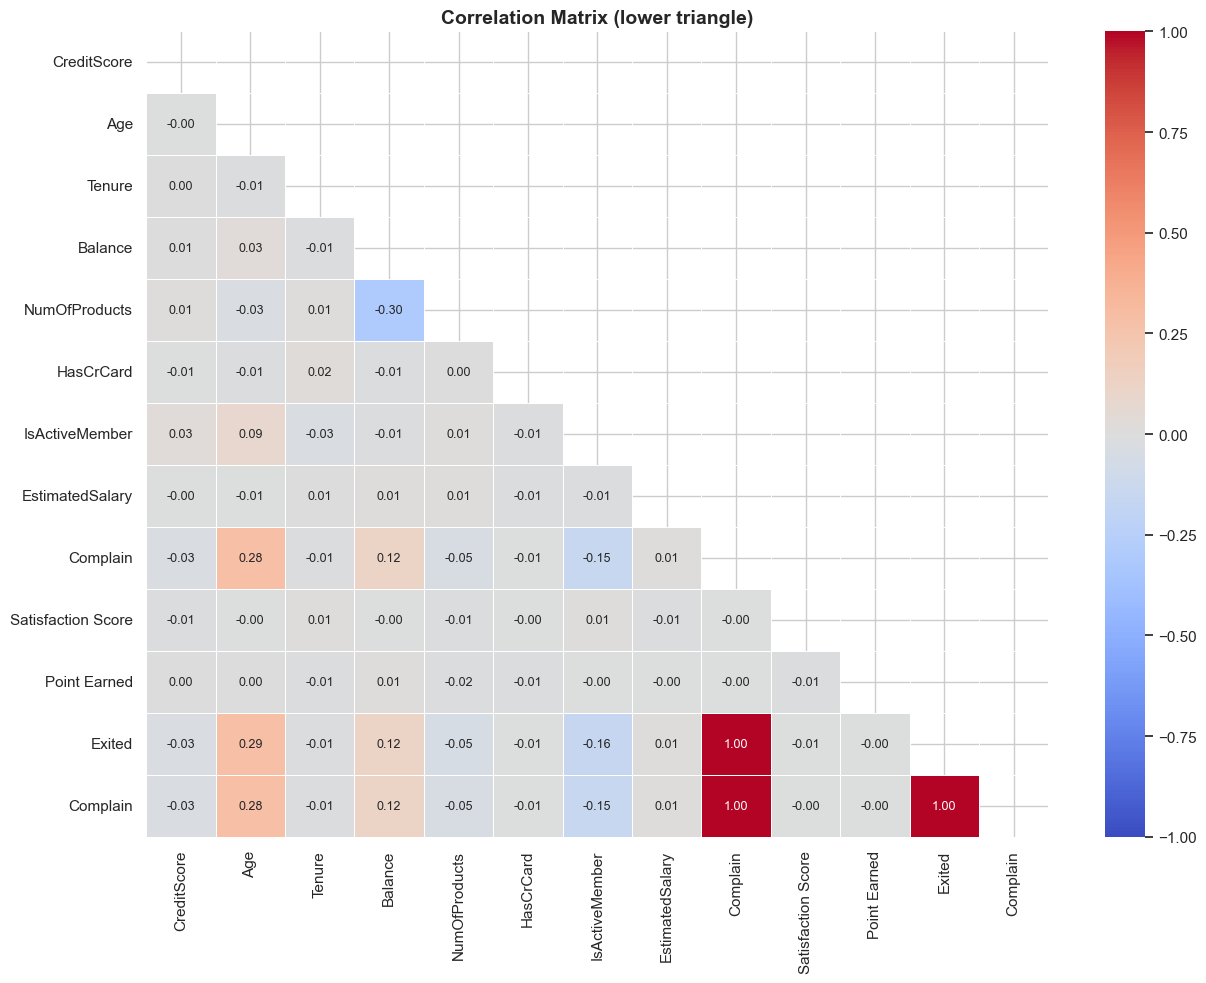


Correlations with target variable (Exited):
Complain              0.995693
Complain              0.995693
Age                   0.285296
Balance               0.118577
EstimatedSalary       0.012490
Point Earned         -0.004628
Satisfaction Score   -0.005849
HasCrCard            -0.006976
Tenure               -0.013656
CreditScore          -0.026771
NumOfProducts        -0.047611
IsActiveMember       -0.156356


In [6]:
# Include Exited in the correlation to see which features relate to the target
corr_cols = numerical_cols + ['Exited', 'Complain']
corr_matrix = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(13, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))   # upper triangle mask (avoid redundancy)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            mask=mask, ax=ax, linewidths=0.5,
            vmin=-1, vmax=1, center=0,
            annot_kws={'size': 9})
ax.set_title('Correlation Matrix (lower triangle)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print correlations with the target variable, sorted descending
print('\nCorrelations with target variable (Exited):')
print(corr_matrix['Exited'].drop('Exited').sort_values(ascending=False).to_string())

## 6. 🚨 Key Finding: Complain is a Near-Duplicate of Exited

The correlation matrix shows `Complain` ↔ `Exited` ≈ **0.99**.  
This is **not a coincidence** — let's verify with a cross-tabulation.

In [7]:
corr_EC = data['Exited'].corr(data['Complain'])
print(f'Pearson correlation  Exited ↔ Complain : {corr_EC:.4f}')
print()

# Cross-tabulation: rows=Exited, cols=Complain
cross = pd.crosstab(data['Exited'], data['Complain'],
                    rownames=['Exited'], colnames=['Complain'],
                    margins=True)
print('Cross-tabulation:')
print(cross)
print()

# How many cases where Exited ≠ Complain?
mismatch = data[data['Exited'] != data['Complain']].shape[0]
match    = data[data['Exited'] == data['Complain']].shape[0]
print(f'Rows where Exited == Complain : {match:,}  ({match/len(data)*100:.1f}%)')
print(f'Rows where Exited != Complain : {mismatch:,}  ({mismatch/len(data)*100:.1f}%)')
print()
print('⚠️  Conclusion: Complain is essentially a restatement of the target.')
print('   Including it would cause SEVERE data leakage — the model would')
print('   learn to predict churn by checking if the customer complained,')
print('   which is only known *after* churn. It MUST be dropped.')

Pearson correlation  Exited ↔ Complain : 0.9957

Cross-tabulation:
Complain     0     1    All
Exited                     
0         7952    10   7962
1            4  2034   2038
All       7956  2044  10000

Rows where Exited == Complain : 9,986  (99.9%)
Rows where Exited != Complain : 14  (0.1%)

⚠️  Conclusion: Complain is essentially a restatement of the target.
   Including it would cause SEVERE data leakage — the model would
   learn to predict churn by checking if the customer complained,
   which is only known *after* churn. It MUST be dropped.


## 7. Pairplot — Feature Interactions

A **pairplot** plots every numerical feature against every other, with the diagonal showing individual distributions. Colour by `Exited` to see whether combinations of features separate the classes.

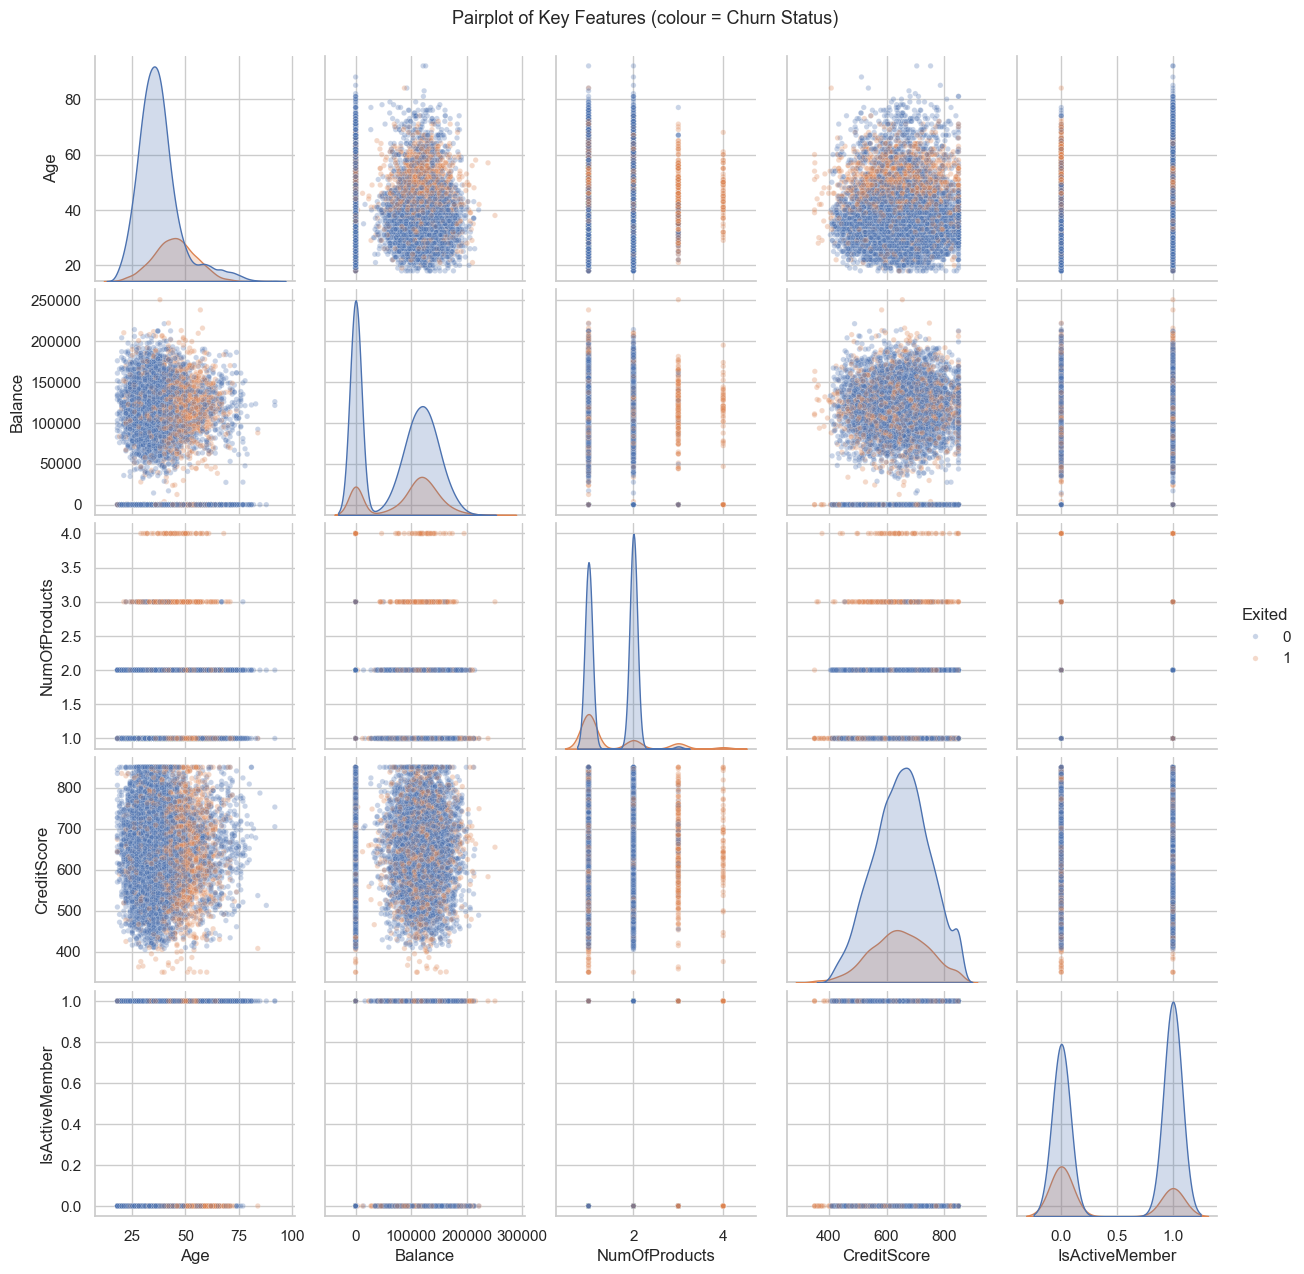

In [8]:
# Use a subset of the most informative features to keep the plot readable
pairplot_cols = ['Age', 'Balance', 'NumOfProducts', 'CreditScore', 'IsActiveMember', 'Exited']

g = sns.pairplot(df[pairplot_cols], hue='Exited',
                 palette={0: '#4C72B0', 1: '#DD8452'},
                 plot_kws={'alpha': 0.3, 's': 15},
                 diag_kind='kde')
g.fig.suptitle('Pairplot of Key Features (colour = Churn Status)', y=1.02, fontsize=13)
plt.show()

---
## ✅ EDA Summary & Decisions for Next Steps

| Finding | Action in N3/N4 |
|---|---|
| `Complain` ≈ 99% correlated with target | **Drop** — data leakage |
| `RowNumber`, `CustomerId`, `Surname` carry no signal | **Drop** — identifiers |
| Target variable is 80/20 imbalanced | **Resample** with SMOTE in N4 |
| Numerical features have different scales | **Standardise** with CustomScaler in N4 |
| Categorical features are text strings | **One-hot encode** in N4 |
| `HasCrCard`, `IsActiveMember` are binary (0/1) | **Do NOT scale** these in N4 |
| `Age`, `Balance`, `NumOfProducts` show visual separation | **Key predictors** for the model |

➡️ Continue to **N3_data_cleaning**.